## Desafío 3, One hit wonders.

#### Grupo 1

Marcelo Beguisristain beguiris@yahoo.com.ar

Santiago Caraballo santiagocaraballo@gmail.com

Francisco Cossavella franciscocossavella@gmail.com

Maximiliano Zavala maximilian.zvl@gmail.com


## Objetivo

Consultados por una importante discográfica, necesitamos consturir un modelo que le permita a la empresa determinar qué artistas firmar.
Para hacerlo, quieren poder predecir si esos artistas tienen canciones que puedan convertirse en hits o no.
Para responder a esta pregunta, nos proponemos construir un modelo a partir de datos de Spotify que ya están clasificados como hits o misses.

### Importación de librerías:

In [152]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr

plt.rcParams['savefig.bbox'] = "tight"
style.use('dark_background') or plt.style.use('dark_background')

In [67]:
data = pd.read_csv('dataset-of-10s.csv')
data.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1


In [52]:
print(f'Tenemos {data.shape[1]} features y {data.shape[0]} observaciones')

Tenemos 19 features y 6398 observaciones


In [61]:
data.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target'],
      dtype='object')

## Características de los datos

Spotify recolecta mucha información de la música contenida en su plataforma y, en la api de Spotify podemos ver que nuestros features representan:

track: nombre de la pieza.

artist: nombre del artista.

uri: código identificador de Spotify para esa pieza.

danceability: describe qué tanto se puede bailar la pieza musical y se basa en una combinación de elementos musicales como el tempo, la estabilidad rítmica y las regularidades. Un valor de 0 es lo menos bailable y un valor de 1 es lo más bailable. Gilda es muy bailable, Stockhausen no tanto.

energía: una medida de intensidad y actividad, describe música que suele ser fuerte, rápida y ruidosa. Un valor de cero tiene baja energía y uno de 1 tiene alta. Meshuggah tiene alta energía, Arvo Part, no.

key: es la tonalidad de la pieza, va de 1 a 12 siendo C = 1, C# = 2, etc.

loudness: los valores de volumen en db, suelen ir de -60 a 0.

mode: 1 para piezas mayores y 0 para piezas menores.

speachiness: detecta la presencia de palabra hablada. Valores por arriba de 0.66 representan piezas que son casi exclusivamente palabra hablada.

acousticness: una medida de confianza sobre si la pieza es acústica o eléctrica.

instrumentalness: predictor de que la pieza es instrumental.

liveness: detecta la presencia de público en la grabación.

valence: una medida de qué tan positiva o negativa es la pieza, valores cercanos a 1 son muy positivos, valores cercanos a 0 son negativos. es una combinación de tempo, modo, tonalidad y liveness. 

tempo: el tempo que prepondera en la pieza en BPM.

duration_ms: la duración del tema.

time_signature:	una estimación de la métrica que prepondera en la pieza.

chorus_hit:	una medida de aproximadamente cuándo comienza el estribillo de la pieza.

sections: cantidad de secciones que tiene la pieza.

target: variable dicotómica que indica si la pieza fue incluida en el Hot 100 de Billboard en algún momento durante la década comprendida en el dataset.


Además vamos a incorporar datos sobre el año en el que los temas fueron incluí

In [116]:
data.shape

(6398, 19)

In [117]:
data.dtypes

track                object
artist               object
uri                  object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
chorus_hit          float64
sections              int64
target                int64
dtype: object

Esto es consistente con la descripción que nos da Spotify así que no necesitamos convertir datos.

In [107]:
data3.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,Pop,R&B,Rap,Reggae,Reggaeton,Rock,Ska,Soul,Soundtrack,World
count,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,...,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000
mean,0.579338,0.637391,5.200267,-7.580496,0.678441,0.083637,0.247662,0.108587,0.187627,0.463626,...,0.072309,0.070310,0.031989,0.005332,0.000333,0.025325,0.001333,0.001000,0.025325,0.013329
std,0.170009,0.234679,3.616105,5.304442,0.467153,0.089036,0.303208,0.271029,0.157930,0.239226,...,0.259042,0.255711,0.176001,0.072835,0.018254,0.157136,0.036490,0.031607,0.157136,0.114698
min,0.063400,0.000251,0.000000,-40.198000,0.000000,0.022500,0.000001,0.000000,0.019900,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.481000,0.506000,2.000000,-8.266000,0.000000,0.035400,0.021100,0.000000,0.096500,0.273000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.590000,0.684000,5.000000,-6.028000,1.000000,0.047500,0.102000,0.000003,0.121000,0.463000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.694000,0.818000,8.000000,-4.625000,1.000000,0.085400,0.376000,0.001820,0.229000,0.645000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.980000,0.998000,11.000000,-0.155000,1.000000,0.956000,0.996000,0.983000,0.981000,0.974000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Vamos a chequear datos faltantes:

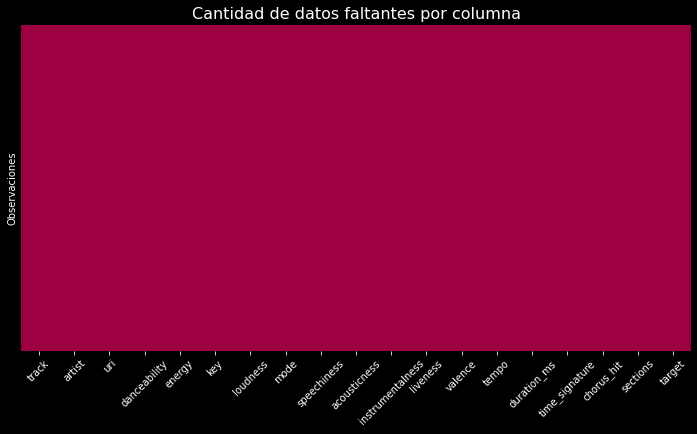

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(data.isnull(), cbar=False, cmap='Spectral');
ax.set_title('Cantidad de datos faltantes por columna', fontdict={'fontsize': 16});
ax.set_ylabel('Observaciones');
ax.set_xlabel('');
ax.tick_params(labelleft=False, left=False);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

No tenemos NA's, vamos a ver cómo se distribuyen las variables numéricas y cómo se relacionan entre sí.

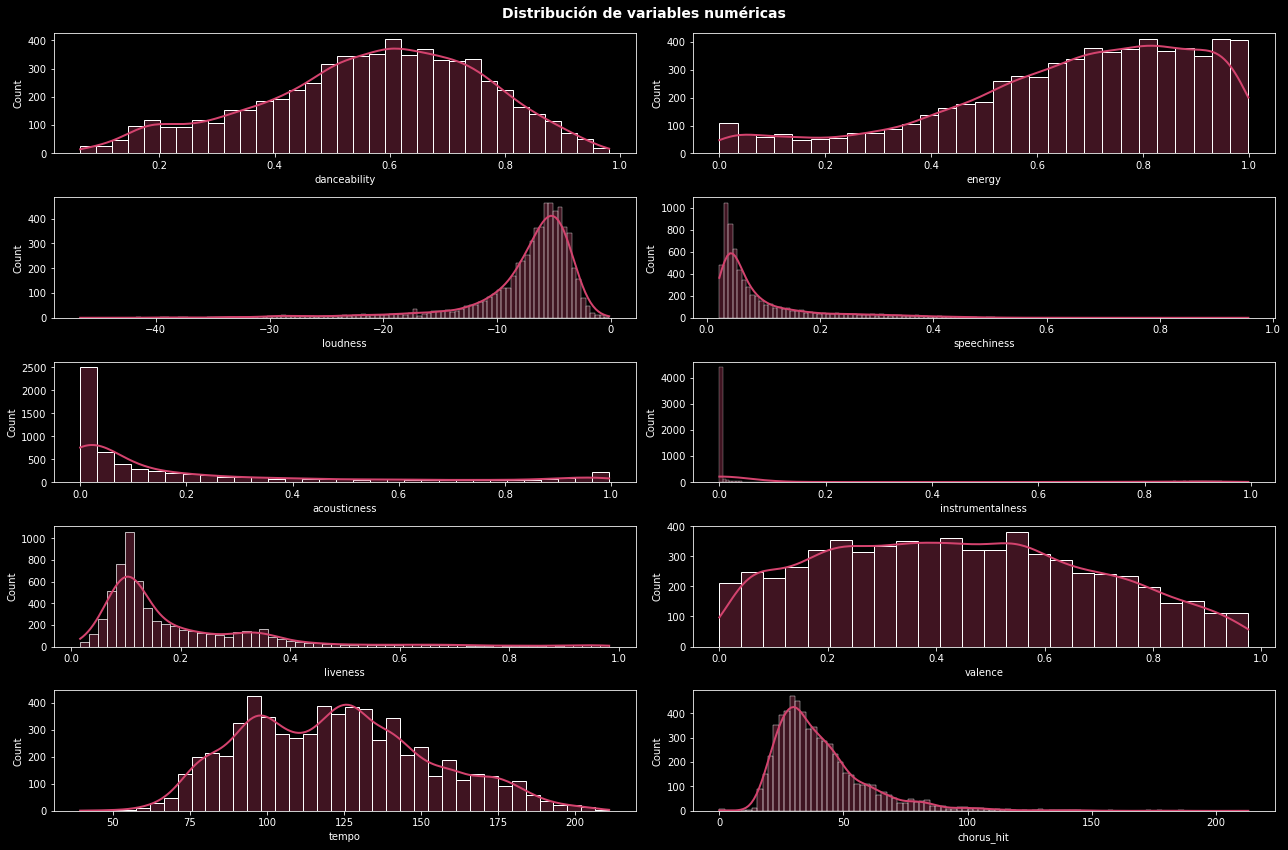

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 12))
axes = axes.flat
columnas_numeric = data.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = data,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = sns.color_palette('magma')[3],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )

    
fig.tight_layout()
plt.subplots_adjust(top = 0.95)
fig.suptitle('Distribución de variables numéricas', fontsize = 14, fontweight = "bold");

Las distribuciones se ven bien, es coherente que speachiness este concentrada hacia valores bajos, indicando que la mayoría de nuestras observaciones no se constituyen completamente de palabra hablada y que loudness está entre 0 y -10.

Vamos a ver las correlaciones entre nuestras variables.

In [12]:
def matrix_corr(corr_mat):
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = data.select_dtypes(include=['float64', 'int']).corr(method='pearson')
matrix_corr(corr_matrix).head(5)

,variable_1,variable_2,r,abs_r
12,energy,loudness,0.774536,0.774536
21,loudness,energy,0.774536,0.774536
41,acousticness,energy,-0.734853,0.734853
14,energy,acousticness,-0.734853,0.734853
42,acousticness,loudness,-0.648717,0.648717


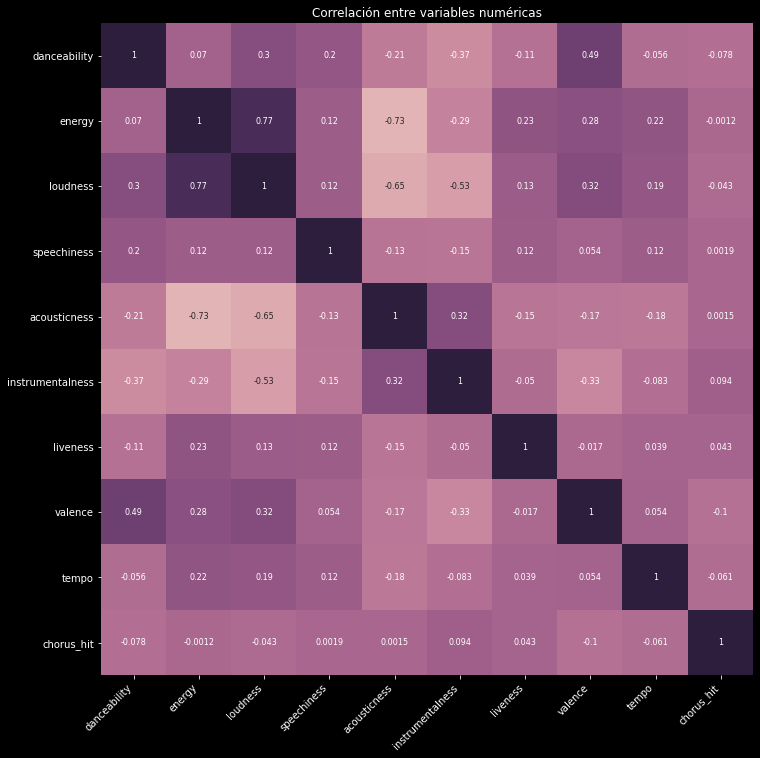

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.cubehelix_palette(as_cmap=True),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.set_title("Correlación entre variables numéricas")
ax.tick_params(labelsize = 10)

De nuevo, dado cómo están construídas algunas de nuestras features, las correlaciones son esperables. Por ejemplo entre valence y danceability o loudness y energy.

Vamos a ver el balance de nuestro target y ya podemos empezar a fitear algún modelo.

In [23]:
data.target.value_counts()

1    3199
0    3199
Name: target, dtype: int64

Está deliciosamente balanceado, separamos nuestros features y target. 

In [129]:
X = data.drop(['target', 'artist', 'uri', 'track'], axis=1)
y = data.target

Armamos sets de entrenamiento y testeo.

In [130]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                y,
                                                train_size=0.8,
                                                random_state=1234)

Ahora escalamos nuestros features de entrenamiento y le enseñamos eso a los features de testeo.

In [131]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)
pd.DataFrame(Xtrain).describe().round()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,5118.0,5118.0,5118.0,5118.0,5118.0,5118.0,5118.0,5118.0,5118.0,5118.0,5118.0,5118.0,5118.0,5118.0,5118.0
mean,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-3.0,-3.0,-1.0,-6.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-3.0,-2.0,-11.0,-2.0,-2.0
25%,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
50%,0.0,0.0,0.0,0.0,1.0,-0.0,-1.0,-1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
75%,1.0,1.0,1.0,1.0,1.0,0.0,0.0,-0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
max,2.0,1.0,2.0,1.0,1.0,8.0,3.0,3.0,5.0,2.0,3.0,11.0,3.0,7.0,13.0


Eventualmente tendremos mejores maneras de validar muchos hiperparámetros pero por ahora usamos esta función.

In [122]:
def knn_trainer(X, y, start, stop):
        kf = KFold(n_splits=10, shuffle=True, random_state=1234)
        scores = []
        dist = ['euclidean', 'manhattan', 'chebyshev'] # además de k validamos tipo de métrica
        weights = ['uniform', 'distance'] # y peso

        for i in range(start, stop):
            for j in dist:
                for k in weights:
                    model = KNeighborsClassifier(n_neighbors=i, metric=j, weights=k)
                    cv_scores = cross_val_score(model, Xtrain, ytrain, cv=kf)
                    dict_row_score = {'score_medio':np.mean(cv_scores),
                                      'score_std':np.std(cv_scores), 'n_neighbors':i, 'dist':j, 'weight':k}
                    scores.append(dict_row_score)
        scores_df = pd.DataFrame(scores)
        scores_df['limite_inferior'] = scores_df['score_medio'] - scores_df['score_std']
        scores_df['limite_superior'] = scores_df['score_medio'] + scores_df['score_std']
        return scores_df

In [132]:
scores = knn_trainer(Xtrain, ytrain, 1, 21)
scores.head()

,score_medio,score_std,n_neighbors,dist,weight,limite_inferior,limite_superior
0,0.734068,0.018859,1,euclidean,uniform,0.715210,0.752927
1,0.734068,0.018859,1,euclidean,distance,0.715210,0.752927
2,0.742081,0.015671,1,manhattan,uniform,0.726411,0.757752
3,0.742081,0.015671,1,manhattan,distance,0.726411,0.757752
4,0.722936,0.017565,1,chebyshev,uniform,0.705371,0.740502


Vamos a instanciar un modelo con cada uno de los hiperparámetros seleccionados en la validación cruzada.

In [133]:
scores[scores.score_medio == scores.score_medio.max()]

,score_medio,score_std,n_neighbors,dist,weight,limite_inferior,limite_superior
75,0.795814,0.02716,13,manhattan,distance,0.768654,0.822974


In [134]:
knn_model = KNeighborsClassifier(n_neighbors=13, metric='manhattan', weights='distance')
fit = knn_model.fit(Xtrain, ytrain)

In [135]:
ypred = knn_model.predict(Xtest)

In [136]:
accuracy_score(ytest, ypred)

0.80234375

Es un muy buen accuracy para un primer modelo, miremos la matriz y de confusión y vamos a ver si podemos mejorarlo con otros modelos.

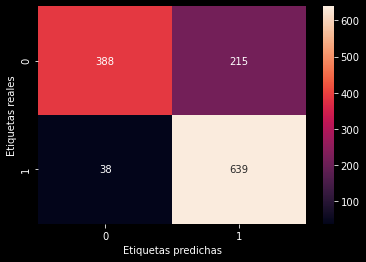

In [137]:
sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

Miremos las probabilidades de clasificar correcta o incorrectamente los temas como hits.

In [138]:
cm = confusion_matrix(ytest, ypred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

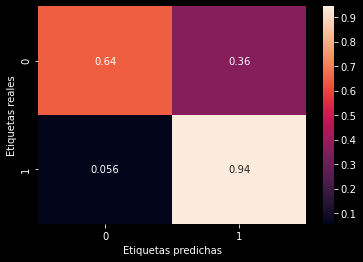

In [139]:
sns.heatmap(cm_normalized, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

Tenemos una probabilidad bastante alta de cometer un error de tipo 1 y decir que un tema es un hit cuando en realidad no lo es, este tipo de error a la hora de hacer una inversión en producir a un artista es altamente problemática. Vamos a probar creando algunas features y después utilizando un modelo de regresión logística a ver si podemos mejorar este problema.

In [143]:
logit_model = LogisticRegression(penalty='none')
logit_model.fit(Xtrain, ytrain)

LogisticRegression(penalty='none')

In [146]:
ypred = logit_model.predict(Xtest)

In [147]:
accuracy_score(ytest, ypred)

0.8140625

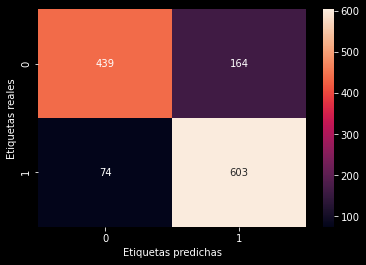

In [149]:
sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='.0f')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [150]:
cm = confusion_matrix(ytest, ypred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

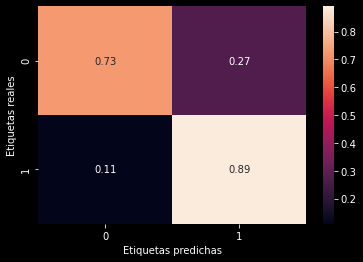

In [153]:
sns.heatmap(cm_normalized, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

Con este modelo nos acercamos un poco más a reducir la probabilidad de cometer un error de tipo 1.